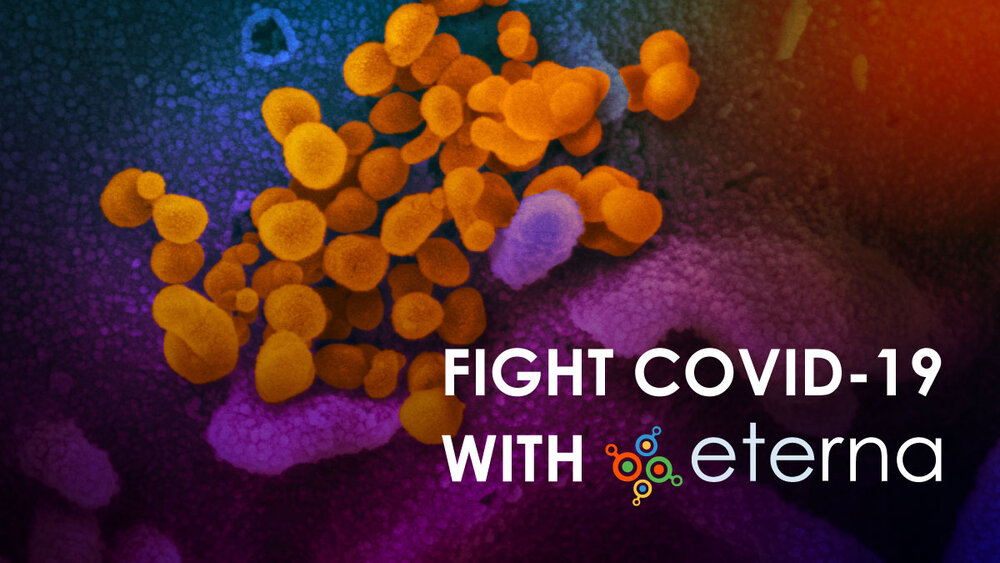

# Problems : 
* One of the biggest challenges right now is how to design super stable messenger RNA molecules (mRNA).
* Researchers have observed that RNA molecules have the tendency to spontaneously degrade. This is a serious limitation--a single cut can render the mRNA vaccine useless.

# Goal:
we are looking to leverage the data science expertise of the Kaggle community to develop models and design rules for RNA degradation. Your model will predict likely degradation rates at each base of an RNA molecule, trained on a subset of an Eterna dataset comprising over 3000 RNA molecules (which span a panoply of sequences and structures) and their degradation rates at each position. We will then score your models on a second generation of RNA sequences that have just been devised by Eterna players for COVID-19 mRNA vaccines. These final test sequences are currently being synthesized and experimentally characterized at Stanford University in parallel to your modeling efforts -- Nature will score your models! 

# Summary:
1. EDA (Exploratory Data Analysis)
2. Features engineering & Pre-processing
3. Modeling
4. Optimization

# EVALUATION

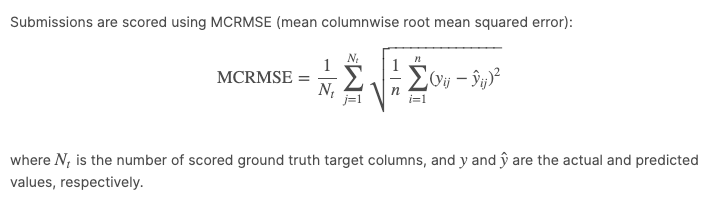

# DATA DESCRIPTION

In this competition, you will be predicting the degradation rates at various locations along RNA sequence.

There are multiple ground truth values provided in the training data. While the submission format requires all 5 to be predicted, only the following are scored: reactivity, deg_Mg_pH10, and deg_Mg_50C.

# COLUMNS


* id - An arbitrary identifier for each sample.
* seq_scored - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* seq_length - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* sequence - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).
* structure - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.
* reactivity - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.
* deg_pH10 - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
* deg_Mg_pH10 - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
* deg_50C - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
* deg_Mg_50C - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).
* *_error_* - An array of floating point numbers, should have the same length as the corresponding reactivity or deg_* columns, calculated errors in experimental values obtained in reactivity and deg_* columns.
* predicted_loop_type - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = "/kaggle/input/stanford-covid-vaccine/"

In [ ]:
path_npy = "/kaggle/input/stanford-covid-vaccine/bpps/"

In [ ]:
train = pd.read_json(f"{path}train.json", lines=True)
test = pd.read_json(f"{path}test.json", lines=True)
submission = pd.read_csv(f"{path}sample_submission.csv")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# EDA (EXPLORATORY DATA ANALYSIS)

Let's look together columns and types variable of data train and test set.

In [ ]:
train.dtypes.value_counts().plot.bar()

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(train.isna(), cbar=False)
plt.title("Train set global view")
plt.show()

* This is good news, because I don't see any missing value.

In [ ]:
print('train shape :',train.shape)
print('test shape :',test.shape)
print('submission shape :', submission.shape)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
submission.head()

In [ ]:
train.describe()

In [ ]:
import seaborn as sns

In [ ]:
fig, axe = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train['signal_to_noise'], ax=axe[0])
sns.countplot(train['SN_filter'], ax=axe[1])

axe[0].set_title('Distribution  Signal/Noise ')
axe[1].set_title('Signal/Noise Filter');

In [ ]:
One_sample = train.iloc[0]
One_sequence = One_sample["sequence"]
One_structure = One_sample["structure"]
One_predicted_loop_type = One_sample["predicted_loop_type"]
One_reactivity = One_sample["reactivity"]

In [ ]:
print("One_sequence :",One_sequence)
print("One_structure :",One_structure)
print("One_predicted_loop_type :",One_predicted_loop_type)
print("One_reactivity :", One_reactivity)

In [ ]:
len(One_reactivity)

In [ ]:
import collections

* sequence - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

In [ ]:
collections.Counter(One_sequence)

In [ ]:
sum_one_sequence = sum(collections.Counter(One_sequence).values())
sum_one_sequence

* structure - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

In [ ]:
collections.Counter(One_structure)

In [ ]:
sum_one_structure = sum(collections.Counter(One_structure).values())
sum_one_structure

* Predicted_loop_type - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [ ]:
collections.Counter(One_predicted_loop_type)

In [ ]:
sum_one_predicted_loop_type = sum(collections.Counter(One_predicted_loop_type).values())
sum_one_predicted_loop_type

NB: These different steps make it possible to verify the integrity of the data. :-)

Additional Notes:

* Minimum value across all 5 conditions must be greater than -0.5.
* Mean signal/noise across all 5 conditions must be greater than 1.0. [Signal/noise is defined as mean( measurement value over 68 nts )/mean( statistical error in measurement value over 68 nts)] To help ensure sequence diversity, the resulting sequences were clustered into clusters with less than 50% sequence similarity, and the 629 test set sequences were chosen from clusters with 3 or fewer members. That is, any sequence in the test set should be sequence similar to at most 2 other sequences.

Note that these filters have not been applied to the 2400 RNAs in the public training data train.json — some of those measurements have negative values or poor signal-to-noise, or some RNA sequences have near-identical sequences in that set. But we are providing all those data in case competitors can squeeze out more signal.


# FEATURE ENGINEERING

In [ ]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

The bpps folder contains Base Pairing Probabilities matrices for each sequence. These matrices give the probability that each pair of nucleotides in the RNA forms a base pair. Each matrix is a symmetric square matrix the same length as the sequence. For a complete EDA of the bpps folder, see this notebook [here](https://www.kaggle.com/hidehisaarai1213/openvaccine-checkout-bpps?scriptVersionId=42460013).

In [ ]:
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"{path_npy}{mol_id}.npy").sum(axis=1))
    return bpps_arr

In [ ]:
def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"{path_npy}{mol_id}.npy").max(axis=1))
    return bpps_arr

In [ ]:
def read_bpps_nb(df):
    #mean and std from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"{path_npy}{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

In [ ]:
train['bpps_sum'] = read_bpps_sum(train)
train['bpps_max'] = read_bpps_max(train)
train['bpps_nb'] = read_bpps_nb(train)

In [ ]:
test['bpps_sum'] = read_bpps_sum(test)
test['bpps_max'] = read_bpps_max(test)
test['bpps_nb'] = read_bpps_nb(test)

In [ ]:
train[train.columns[-3:]].head()

In [ ]:
len(train[train.columns[-3]][0])

In [ ]:
test[test.columns[-3:]].head()

In [ ]:
len(test[test.columns[-3]][0])

In [ ]:
train_set = train.copy()
test_set = test.copy()

In [ ]:
import json

In [ ]:
train_json = train_set.to_json(orient='table')
test_json = test_set.to_json(orient='table')

In [ ]:
train_json = json.loads(train_json)
test_json = json.loads(test_json)
train_json = train_json["data"]
test_json = test_json["data"]

In [ ]:
for line in train_json:
    line['step'] = list(range(line['seq_scored']))
    line['sequence'] = list(line['sequence'])
    line['structure'] = list(line['structure'])
    line['predicted_loop_type'] = list(line['predicted_loop_type'])

In [ ]:
df_data_train_set = pd.json_normalize(data = train_json, 
                            record_path ='reactivity',  
                            meta =['id','signal_to_noise',
                                  'SN_filter','seq_length','seq_scored']) 
df_data_train_set.rename(columns={0:'reactivity'}, inplace=True)
df_data_train_set['step'] = pd.json_normalize(data = train_json, record_path ='step')
df_data_train_set['sequence'] = pd.json_normalize(data = train_json, record_path ='sequence')
df_data_train_set['structure'] = pd.json_normalize(data = train_json, record_path ='structure')
df_data_train_set['predicted_loop_type'] = pd.json_normalize(data = train_json, record_path ='predicted_loop_type')
df_data_train_set['reactivity_error'] = pd.json_normalize(data = train_json, record_path ='reactivity_error')
df_data_train_set['deg_Mg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_Mg_pH10')
df_data_train_set['deg_error_Mg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_error_Mg_pH10')
df_data_train_set['deg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_pH10')
df_data_train_set['deg_error_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_error_pH10')
df_data_train_set['deg_Mg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_Mg_50C')
df_data_train_set['deg_error_Mg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_error_Mg_50C')
df_data_train_set['deg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_50C')
df_data_train_set['deg_error_50C'] = pd.json_normalize(data = train_json, record_path ='deg_error_50C')
df_data_train_set['bpps_sum'] = pd.json_normalize(data = train_json, record_path ='bpps_sum')
df_data_train_set['bpps_max'] = pd.json_normalize(data = train_json, record_path ='bpps_max')
df_data_train_set['bpps_nb'] = pd.json_normalize(data = train_json, record_path ='bpps_nb')

df_data_train_set.set_index(['id','step'], inplace=True)

In [ ]:
df_data_train_set.head()

In [ ]:
for line in test_json:
    line['step'] = list(range(line['seq_scored']))
    line['sequence'] = list(line['sequence'])
    line['structure'] = list(line['structure'])
    line['predicted_loop_type'] = list(line['predicted_loop_type'])

In [ ]:
df_data_test_set = pd.json_normalize(data = test_json,
                         record_path = 'sequence',
                        meta = ['id','seq_length','seq_scored'])
df_data_test_set.rename(columns={0:'sequence'},inplace=True)
df_data_test_set['step'] = pd.json_normalize(data = test_json,record_path = 'step')
df_data_test_set['sequence'] = pd.json_normalize(data = test_json,record_path = 'sequence')
df_data_test_set['structure'] = pd.json_normalize(data = test_json,record_path = 'structure')
df_data_test_set['predicted_loop_type'] = pd.json_normalize(data = test_json,record_path = 'predicted_loop_type')
df_data_test_set['bpps_sum'] = pd.json_normalize(data = test_json, record_path ='bpps_sum')
df_data_test_set['bpps_max'] = pd.json_normalize(data = test_json, record_path ='bpps_max')
df_data_test_set['bpps_nb'] = pd.json_normalize(data = test_json, record_path ='bpps_nb')

df_data_test_set.set_index(['id','step'], inplace=True)

In [ ]:
public_test_df = df_data_test_set.query("seq_length == 107").copy()
private_test_df = df_data_test_set.query("seq_length == 130").copy()

In [ ]:
public_test_df.head(3)

In [ ]:
private_test_df.head(3)

# ENCODAGE DATA

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import copy

In [ ]:
Encoding = LabelEncoder()
quantitative_train = [cols for cols in df_data_train_set.columns if df_data_train_set[cols].dtype == 'object']
quantitative_test = [cols for cols in df_data_test_set.columns if df_data_test_set[cols].dtype == 'object']
df_train_set_encode = copy.deepcopy(df_data_train_set)
df_test_set_encode = copy.deepcopy(df_data_test_set)
for cols in quantitative_train:
        df_train_set_encode[cols] = Encoding.fit_transform(df_train_set_encode[cols])
for cols in quantitative_test:
        df_test_set_encode[cols] = Encoding.fit_transform(df_test_set_encode[cols])

In [ ]:
df_train_set_encode.head(3)

In [ ]:
df_test_set_encode.head(3)

In [ ]:
y = df_train_set_encode[target_cols]

# MODELING

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
list_of_model = []

In [ ]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [ ]:
rideCV = MultiOutputRegressor(estimator=RidgeCV(alphas = alphas))
lassoCV = MultiOutputRegressor(estimator=LassoCV(alphas = None, cv = 10))
ElasticNet = MultiOutputRegressor(estimator=ElasticNet(alpha=0.01, l1_ratio=0.5))
RandomForest = MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=2, random_state=0))
AdaBoost = MultiOutputRegressor(estimator=AdaBoostRegressor(random_state=0, n_estimators=100))
SVR = MultiOutputRegressor(estimator=SVR(C=1.0, epsilon=0.2))
DecisionTree = MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=3,random_state=0))
KNN = MultiOutputRegressor(estimator=KNeighborsRegressor())

In [ ]:
list_of_model = {
                'RandomForest': RandomForest,
                'DecisionTree': DecisionTree,
                'SVR': SVR,
                'KNN': KNN}

In [ ]:
columns = df_test_set_encode.columns
columns

In [ ]:
def standard_scale(X_train, X_test):
    preprocessor = StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test 

In [ ]:
#X_train, X_test = standard_scale(df_train_set_encode[columns],df_test_set_encode)

In [ ]:
def Evalution_model(model, key):
    model.fit(df_train_set_encode[columns], y)
    y_pred = model.predict(df_test_set_encode)
    
    print("{} Performance for training and testing set".format(key))
    print("----------------------------------------------------------------------------")
    print('Score :',model.score(df_train_set_encode[columns], y))
    return y_pred

In [ ]:
y_predict = []

In [ ]:
#for key, model in list_of_model.items():
#    y_predict = Evalution_model(model, key)

In [ ]:
y_predict

In [ ]:
xgb_model = xgb.XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=100, min_child_weight=2, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=0)

In [ ]:
xgb_mod = MultiOutputRegressor(estimator=xgb_model)

In [ ]:
xgb_mod.fit(df_train_set_encode[columns], y)
pred_final = xgb_mod.predict(df_test_set_encode)

In [ ]:
print('Score :',xgb_mod.score(df_train_set_encode[columns], y))

In [ ]:
pred_final.shape

In [ ]:
pred_final

# Bi-GRU

In [ ]:
import plotly.express as px
import tensorflow.keras.layers as L
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
tf.random.set_seed(2020)
np.random.seed(2020)

In [ ]:
y_true = tf.random.normal((32, 68, 3))
y_pred = tf.random.normal((32, 68, 3))

In [ ]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [ ]:
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True,
                                 kernel_initializer='orthogonal'))

In [ ]:
def Build_Model(embed_size, seq_len=107, pred_len=68, dropout=0.5, sp_dropout=0.2, embed_dim=200,
                hidden_dim=256, n_layers=3):
    
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [ ]:
def pandas_list_to_array(df):
    """
    Input: dataframe of shape (x, y), containing list of length l
    Return: np.array of shape (x, l, y)
    """
    
    return np.transpose(
        np.array(df.values.tolist()),
        (0, 2, 1)
    )

In [ ]:
def preprocess_inputs(df, token2int, cols=['sequence', 'structure', 'predicted_loop_type']):
    return pandas_list_to_array(
        df[cols].applymap(lambda seq: [token2int[x] for x in seq])
    )

In [ ]:
train = train.query("signal_to_noise >= 1")

In [ ]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

train_inputs = preprocess_inputs(train, token2int)
train_labels = pandas_list_to_array(train[target_cols])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train_inputs, train_labels, test_size=.1, random_state=34, stratify=train.SN_filter)

In [ ]:
public_test_df = test.query("seq_length == 107").copy()
private_test_df = test.query("seq_length == 130").copy()

In [ ]:
public_inputs_test = preprocess_inputs(public_test_df, token2int)
private_inputs_test = preprocess_inputs(private_test_df, token2int)

# BUILD AND TRAIN MODEL Bi-GRU

In [ ]:
model = Build_Model(embed_size=len(token2int))
model.summary()

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_valid, y_valid),batch_size=64,epochs=75,verbose=2,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(patience=5),
            tf.keras.callbacks.ModelCheckpoint('model.h5')
        ]
)

In [ ]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='Training History')
fig.show()

# PUBLIC AND PRIVATE PREDICTION

In [ ]:
model_public = Build_Model(seq_len=107, pred_len=107, embed_size=len(token2int))
model_private = Build_Model(seq_len=130, pred_len=130, embed_size=len(token2int))

model_public.load_weights('model.h5')
model_private.load_weights('model.h5')

In [ ]:
pred_public = model_public.predict(public_inputs_test)
pred_private = model_private.predict(private_inputs_test)

In [ ]:
preds_gru = []

In [ ]:
for df, pred in [(public_test_df, pred_public), (private_test_df, pred_private)]:
    for i, uid in enumerate(df.id):
        single_pred = pred[i]

        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_gru.append(single_df)

submit_df = pd.concat(preds_gru)

In [ ]:
submission.shape

In [ ]:
submission = submit_df[['id_seqpos']].merge(submit_df, on=['id_seqpos'])

In [ ]:
submission.head()

In [ ]:
submission.shape

In [ ]:
submission.to_csv('gru_submission.csv', index=False)
print("Great sub!")